# Course 3684 - Advanced Topics in Machine Learning

<br>

# Assignment #2a
# Explainable AI practical work

---

#### General instructions:
1. Submission is individual.
2. Submission must include python code and a written report.
3. You may use external libraries. Specify all required libraries in a proper manner.
4. Your code must be reproducible. Code that will not run will result in a grade reduction.
5. Your report should be clear, coherent, and concise. The report should not exceed 10 pages.
6. Invest thoughts and considerations to the way you choose to present data and experimental
results.
7. All figure and plots should include captions, labels and data units. Pay attention to data
visualization guidelines.
8. Make sure to use correct ML methodologies and justify your selections (split the data to
train/test, tune hyperparameters, report relevant performance measures).

---



Prerequisite

In [ ]:
!pip install --q lime
# !pip install pytorch-transformers
!pip install --q transformers
!pip install --q datasets
# !pip install --q torchtext
# !pip install --q torchdata
!pip install --q eli5

     |████████████████████████████████| 275 kB 34.9 MB/s 
     |████████████████████████████████| 4.2 MB 36.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
     |████████████████████████████████| 84 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 346 kB 22.6 MB/s 
     |████████████████████████████████| 1.1 MB 59.9 MB/s 
     |████████████████████████████████| 140 kB 85.8 MB/s 
     |████████████████████████████████| 212 kB 57.5 MB/s 
     |████████████████████████████████| 127 kB 54.8 MB/s 
     |████████████████████████████████| 271 kB 77.1 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 82.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

Imports

In [ ]:
import os
import time 

import gc
import pickle
import random

import numpy as np
import pandas as pd

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split


import torch
from torch import nn
import torch.optim as optim
from torch.cuda import empty_cache
from torch.utils.data import DataLoader
from transformers import BertModel,BertTokenizer,BertForSequenceClassification

import torchtext

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.base import TransformerMixin 
from sklearn.svm import LinearSVC 
from sklearn.pipeline import Pipeline 

Warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Google Drive

In [ ]:
from google.colab import drive  
_ = drive.mount(r'/content/drive',force_remount=True)

data_dir = os.getcwd() + '/drive/My Drive/גיבוי מחשב עבודה וימאו/IDC/ATML/Assignment2/'
os.listdir(data_dir)

Mounted at /content/drive


['3684_2022_HW2a.pdf',
 '3684_2022_HW2b.pdf',
 '3684_2022_HW2b.gdoc',
 'yelp_labelled.txt',
 'imdb_labelled.txt',
 'amazon_cells_labelled.txt',
 'results',
 'logs']

# The goal of this assignment is to demonstrate explainable AI methods for classification models.

Summarize all your work in a scientific/professional report.


1. Choose one of the following datasets
(Choose a different dataset than the one you used for HW1):
- Telco customer churn
- Default of credit card
- Hotel booking demand

I choose a textual dataet, to experement with explanability on Language Models.


In [ ]:
df_yelp = pd.read_table(data_dir + 'yelp_labelled.txt')
df_imdb = pd.read_table(data_dir + 'imdb_labelled.txt')
df_amz = pd.read_table(data_dir + 'amazon_cells_labelled.txt')


frames = [df_yelp,df_imdb,df_amz]

keys = ['Yelp','IMDB','Amazon']

for colname in frames:
    colname.columns = ["Message","Target"]

# dropping the very long reviews
frames[1] = frames[1][frames[1].Message.str.len()<300]

# dataframe
df = pd.concat(frames,keys=keys)
df.Message = df.Message.str.lower()

frames.append(df)
keys.append('All')
df.head()

Message  Target
Yelp 0                                 crust is not good.       0
     1          not tasty and the texture was just nasty.       0
     2  stopped by during the late may bank holiday of...       1
     3  the selection on the menu was great and so wer...       1
     4     now i am getting angry and i want my damn pho.       0

In [ ]:
nlp = spacy.load('en')
stopwords = list(STOP_WORDS)


2. Explore the dataset and its properties using standard Exploratory Data Analysis methods

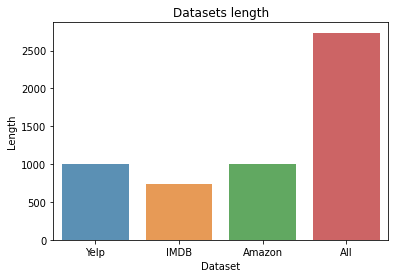

In [ ]:
lens = {k:len(f) for f,k in zip(frames,keys)}
sns.barplot(x=list(lens.keys()), y=list(lens.values()), alpha=0.8)
plt.title("Datasets length")
plt.ylabel('Length')
plt.xlabel('Dataset');

''

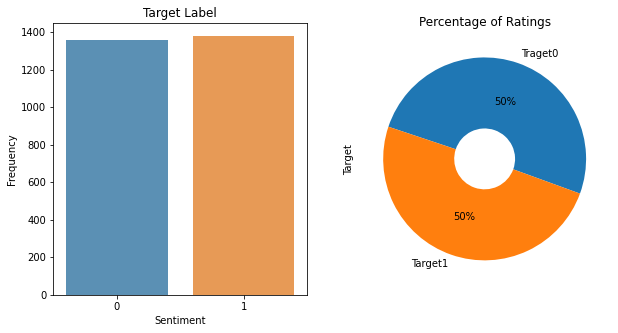

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
x_rating = df.Target.value_counts()
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Target Label")
plt.ylabel('Frequency')
plt.xlabel('Sentiment');

plt.subplot(1, 2, 2)
plt.title('Percentage of Ratings')
df.Target.value_counts().plot(kind='pie', labels=['Traget0', 'Target1'],wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20)

;

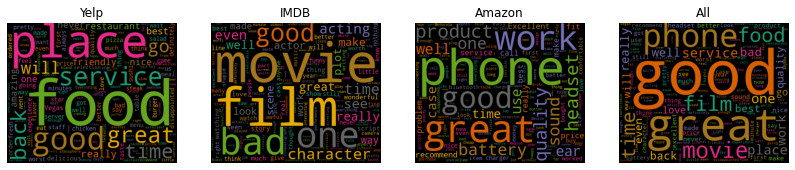

In [ ]:
def create_wc(ax,text,title):
    word_cloud = WordCloud(width=400, height=330, max_words=150,colormap="Dark2",collocations = False).generate(text)
    ax.imshow(word_cloud)
    ax.set_title(title)
    ax.axis('off')


fig = plt.figure(figsize=(14,5))

for i in range(len(frames)):
    ax = fig.add_subplot(1,len(frames),i+1)
    text = " ".join(frames[i].Message)
    create_wc(ax,text,keys[i])

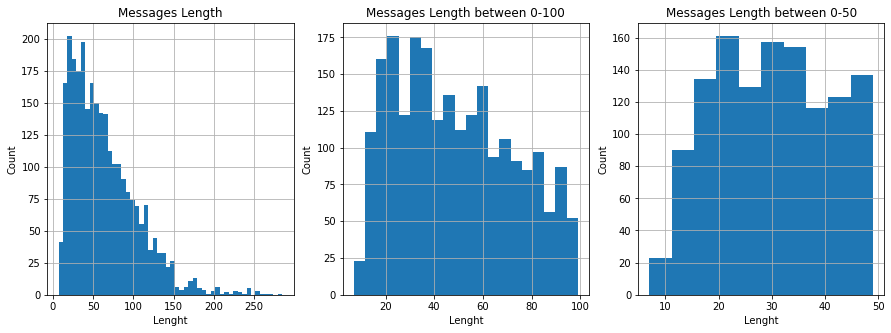

In [ ]:
plt.figure(figsize=(15, 5))

lens = df.Message.str.len()

plt.subplot(1, 3, 1)
lens.hist(bins=50);
plt.title("Messages Length")
plt.ylabel('Count')
plt.xlabel('Lenght');


plt.subplot(1, 3, 2)
lens[lens<100].hist(bins=20);
plt.title("Messages Length between 0-100")
plt.ylabel('Count')
plt.xlabel('Lenght');


plt.subplot(1, 3, 3)
lens[lens<50].hist(bins=10);
plt.title("Messages Length between 0-50")
plt.ylabel('Count')
plt.xlabel('Lenght');


3. Define a classification problem based on the chosen dataset.

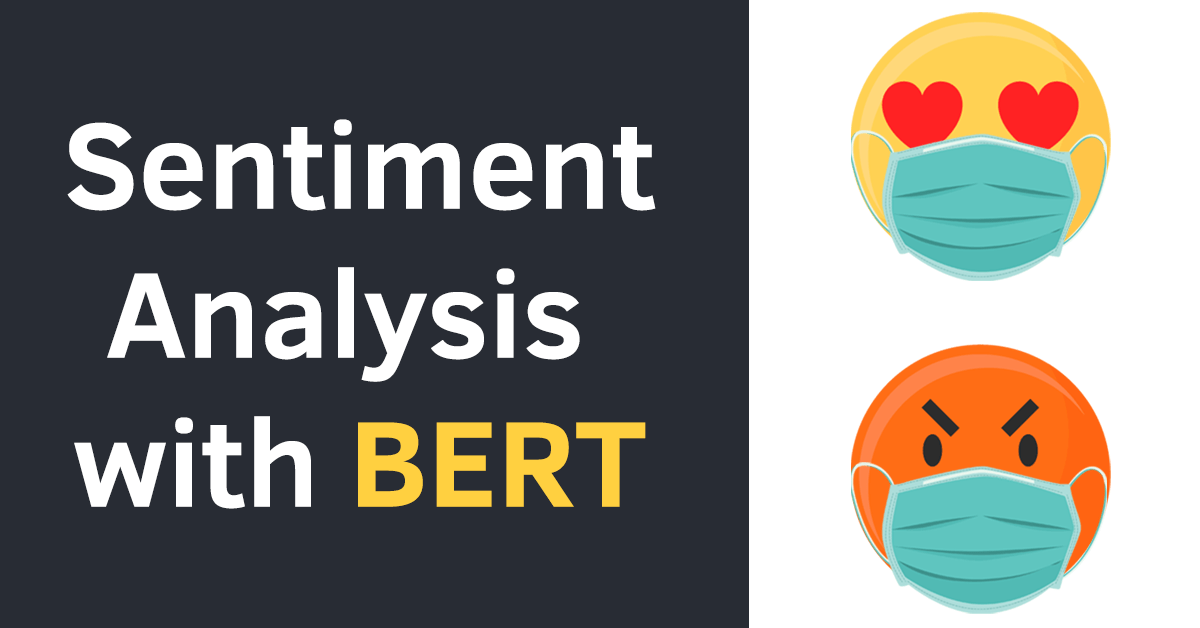

In [ ]:
X = df.Message.values
Y = df.Target.values

x_train_, x_test, y_train_, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=0.2, random_state=42)


x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((1750,), (438,), (547,), (1750,), (438,), (547,))

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x,y

    def __len__(self):
        return len(self.encodings)

dataset_train = Dataset(x_train, y_train)
dataset_val = Dataset(x_val, y_val)
dataset_test = Dataset(x_test, y_test)


4. Train at least 2 classification models on the chosen dataset. Report the performance of the
models.

Create Classification models:

In [ ]:
class classification_pretrained_model(nn.Module):
    def __init__(self,n_classes=1,model_name="bert-base-uncased",max_len=200,batch_size=64):
        super(classification_pretrained_model, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = BertTokenizer.from_pretrained(model_name)
        self.model_bert = BertModel.from_pretrained(model_name)

        self.config = self.model_bert.config

        self.classifier = nn.Sequential(
            nn.Linear(768, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, n_classes, bias=True),            
            nn.Sigmoid()
        )


    def freeze_BERT(self):
        for param in self.model_bert.parameters():
          param.requires_grad = False

    def unfreeze_BERT(self):
        for param in self.model_bert.parameters():
          param.requires_grad = True


    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']


    def forward(self, tokens_bert):

        # features
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]

        # classification
        outputs = self.classifier(features_bert)
        return outputs


Create a Trainer object:

In [ ]:
class myTrainer():
  def __init__(self, model, train_dataset, val_dataset, test_dataset, epochs = 5, model_name = 'basemodel',current_dir = data_dir):
    
    self.model = model
    self.epochs = epochs
    self.model_name = str(model_name)
    self.current_dir = current_dir
    
    self.criterion = nn.BCELoss()
    self.optimizer = optim.Adam(self.model.parameters())
    self.train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    self.val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    self.test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    self.loss_train = []
    self.loss_val = []


  def train(self):
    min_valid_loss = np.inf
    
    # run on all epochs
    print(self.model_name + ': Training \t',end='')
    for e in range(self.epochs):
      # print()

      # train
      for data in self.train_dataloader:
        print('.',end='')
        self.train_loss(data)

      # eval      
      self.model.eval()     # Optional when not using Model Specific layer
      for data in self.val_dataloader:
          self.val_loss(data)
      
      # print progress
      # print(f'Epoch {e+1} \t\t Training Loss: {self.loss_train[-1] / len(self.train_dataloader)} \t\t Validation Loss: {self.loss_val[-1] / len(self.val_dataloader)}')

      # save the optimal model    
      if min_valid_loss > self.loss_val[-1]:
          # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{self.loss_val[-1]:.6f})')
          min_valid_loss = self.loss_val[-1]
          self.save_model()

    # load best model
    self.load_model()      
    

  def train_loss(self,data):
    inputs, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs)  #.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()
      
    # Find the Loss
    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()
    target = self.model(tokens_bert)
    loss = self.criterion(target,labels)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def val_loss(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs) #self.model.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # Find the Loss
    target = self.model(tokens_bert)
    loss = self.criterion(target,labels)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def predict(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval()  
    with torch.no_grad():
      for data in self.test_dataloader:

        inputs, labels = data

        # tokenizer
        tokens_bert = self.model.tokenizing(inputs)
        tokens_bert = tokens_bert.cuda()
        
        target = self.model(tokens_bert)
        target = target.round()

        predictions.extend(target.cpu().detach()[:,0].tolist())
        real_labels.extend(labels.tolist())

    return real_labels,predictions


  def save_model(self):
    # print('Saving the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'wb') as f:
      pickle.dump(self.model, f, pickle.HIGHEST_PROTOCOL)
    # print('done!')


  def load_model(self):
    # print('Loading the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'rb') as f:
      self.model = pickle.load(f)
    # print('done!')


  def plot_losses(self):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(self.loss_train)
    plt.title('Train Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss')

    plt.subplot(1,2,2)
    plt.plot(self.loss_val)
    plt.title('Validation Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss');

Finetune the models:
Each model will be Downloaded, Trained, and Evaluated.

In [ ]:
random.seed(123)

models = ['distilbert-base-uncased','bert-base-uncased']
df = pd.DataFrame(columns=['Model','Accuracy','Loss_Train','Loss_Val'])

def add_result(model_name, real_bert, pred_bert, loss_train, loss_val):
  accuracy_bert = accuracy_score(y_true=real_bert,y_pred=pred_bert)
  df.loc[len(df)] = [model_name,accuracy_bert,loss_train,loss_val]


for model_name in models:

  # model
  model_bert = classification_pretrained_model(model_name=model_name).cuda();
  model_bert.freeze_BERT()

  # train
  trainer_BERT = myTrainer(model_bert,model_name=model_name,train_dataset=dataset_train,val_dataset=dataset_val,test_dataset=dataset_test,epochs=3)
  trainer_BERT.train()

  # predict
  real_bert,pred_bert = trainer_BERT.predict()

  # save model results
  add_result(model_name, real_bert, pred_bert,trainer_BERT.loss_train,trainer_BERT.loss_val)

  # print(df.tBERT_Accuracy.values)

  # free cuda
  model_bert, trainer_BERT = None, None
  gc.collect()
  empty_cache()




Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['vocab_layer_norm.bias', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.5.ffn.lin1.weight', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.bias', 'distilbert.transformer.layer.3.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'dis

distilbert-base-uncased: Training 	....................................................................................

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased: Training 	....................................................................................

Results:

In [ ]:
df

,Model,Accuracy,Loss_Train,Loss_Val
0,distilbert-base-uncased,0.442413,"[1.4428815841674805, 1.4519007205963135, 1.426...","[1.3786108493804932, 1.3812987804412842, 1.387..."
1,bert-base-uncased,0.557587,"[1.3948965072631836, 1.4000496864318848, 1.330...","[1.3897290229797363, 1.4008523225784302, 1.397..."


''

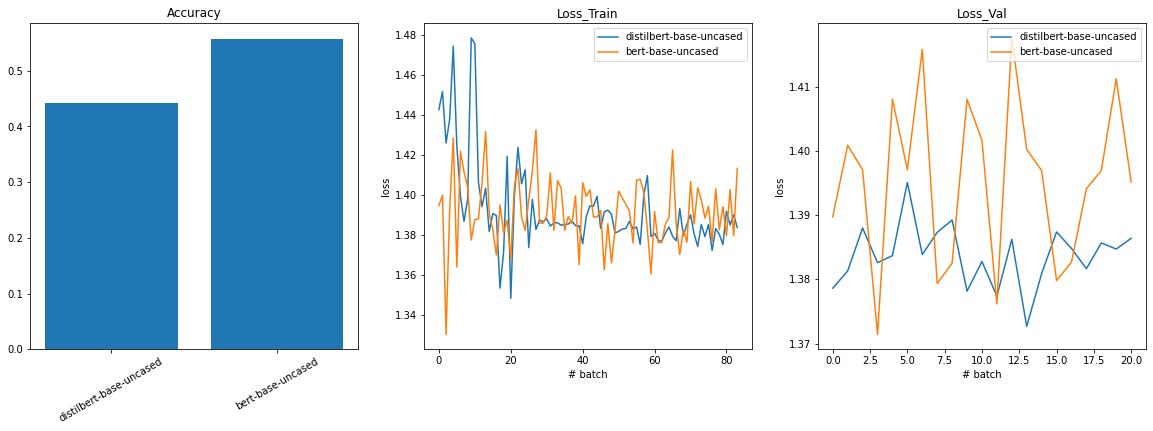

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
x = list(range(len(df)))
plt.bar(x, df.Accuracy, align='center')
plt.xticks(x, df.Model,rotation=30)
plt.title('Accuracy')

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df)):
    y = df[c][i]
    x = list(range(len(y)))
    l = str(df.Model[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

;

Let's see the performence of a pretrained model on the Sentiment Analysis task

In [ ]:
from datasets import load_dataset, Dataset
from datasets.dataset_dict import DatasetDict

from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification

from transformers import TrainingArguments
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer


In [ ]:
d = {'train':Dataset.from_dict({'label':y_train,'text':x_train}),
     'val':Dataset.from_dict({'label':y_val,'text':x_val}),
     'test':Dataset.from_dict({'label':y_test,'text':x_test})
     }

dataset = DatasetDict(d)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True);

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
val_dataset = tokenized_datasets["val"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2);

# freeze
for name, param in model.named_parameters():
     if name.startswith("bert.embeddings") or name.startswith("bert.encoder"):
        param.requires_grad = False

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
training_args = TrainingArguments(output_dir=data_dir + "test_trainer")

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(num_train_epochs=5,per_device_train_batch_size=64,per_device_eval_batch_size=32,output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1750
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 140


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.652667,0.664384
2,No log,0.625559,0.735160
3,No log,0.605317,0.746575
4,No log,0.593367,0.755708
5,No log,0.589465,0.755708


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 438
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 438
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 438
  Batch size = 32
The following co

TrainOutput(global_step=140, training_loss=0.6308260236467634, metrics={'train_runtime': 356.4718, 'train_samples_per_second': 24.546, 'train_steps_per_second': 0.393, 'total_flos': 2302221734400000.0, 'train_loss': 0.6308260236467634, 'epoch': 5.0})

In [ ]:
m = trainer.evaluate(test_dataset)
m

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 547
  Batch size = 32


{'epoch': 5.0,
 'eval_accuracy': 0.7404021937842779,
 'eval_loss': 0.5977456569671631,
 'eval_runtime': 16.4201,
 'eval_samples_per_second': 33.313,
 'eval_steps_per_second': 1.096}

Text(0.5, 1.0, 'Accuracy')

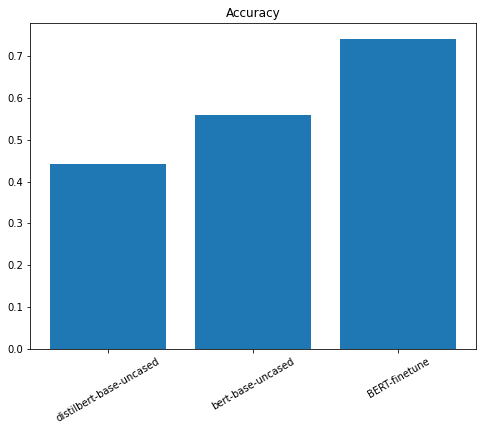

In [ ]:
df.loc[len(df)] = ['BERT-finetune',m['eval_accuracy'],None,None]

plt.figure(figsize=(8,6))

x = list(range(len(df)))
plt.bar(x, df.Accuracy, align='center')
plt.xticks(x, df.Model,rotation=30)
plt.title('Accuracy')

As we know the Yelp model already seen some of the test data, but it doesn't really mather for the perpose of the end goal. Which is to explain these models.


5. Use different explainable AI methods to explain the model predictions for each model.
Discuss the results and relate them to the dataset properties and the selected model.
(You can use the methods covered in class – LIME, SHAP)

##### transformers-interpret
Similar to LIME

Transformers Interpret is a model explainability tool designed to work exclusively with the 🤗 transformers package.

In line with the philosophy of the transformers package Tranformers Interpret allows any transformers model to be explained 

In [ ]:
!pip install --q transformers-interpret

     |████████████████████████████████| 1.4 MB 28.1 MB/s 


This will make sure the logging of HF will not be seen.

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
# from transformers import AutoModelForSequenceClassification, AutoTokenizer


import logging
import re
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)

set_global_logging_level(logging.ERROR, ["transformers", "nlp", "torch", "tensorflow", "tensorboard", "wandb"])

I'll use 2 models. One trained by me, and one already trained by HF.

In [ ]:
# model_name_ = "distilbert-base-uncased-finetuned-sst-2-english"

model_name_ = 'textattack/bert-base-uncased-SST-2'
model_ft_dis = AutoModelForSequenceClassification.from_pretrained(model_name_)
tokenizer_ft_dis = AutoTokenizer.from_pretrained(model_name_)

cls_explainer_ft_dis = SequenceClassificationExplainer(
    model_ft_dis,
    tokenizer_ft_dis)

In [ ]:
word_attributions = cls_explainer_ft_dis(x_test[5])
cls_explainer_ft_dis.visualize()


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (1.00),LABEL_1,1.56,[CLS] meredith m was better than all right . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (1.00),LABEL_1,1.56,[CLS] meredith m was better than all right . [SEP]


In [ ]:
word_attributions = cls_explainer_ft_dis(x_test[100])
cls_explainer_ft_dis.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (1.00),LABEL_0,2.15,[CLS] my husband and i ate lunch here and were very disappointed with the food and service . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (1.00),LABEL_0,2.15,[CLS] my husband and i ate lunch here and were very disappointed with the food and service . [SEP]


This was very good.

My model:

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

In [ ]:
word_attributions = cls_explainer(x_test[5])
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.58),LABEL_0,1.19,[CLS] mere ##dit ##h m was better than all right . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.58),LABEL_0,1.19,[CLS] mere ##dit ##h m was better than all right . [SEP]


In [ ]:
word_attributions = cls_explainer(x_test[100])
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.61),LABEL_0,0.24,[CLS] my husband and i ate lunch here and were very disappointed with the food and service . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.61),LABEL_0,0.24,[CLS] my husband and i ate lunch here and were very disappointed with the food and service . [SEP]


My model did not performe well as the pretrained model. Which make sense.
We can see some word given meaning to the sentiment, while they infact don't contribute any meaning.

For example, `husband`, `lunch`, etc.
Although, I can't really understand everything going on inside the model.
I can see that this is no an optimal model, while the HF model, does not make these kind of mistakes.

##### SHAP
Luckily, SHAP integrates well with 🤗 Transformers.   

In [ ]:
!pip install --q shap


     |████████████████████████████████| 564 kB 18.1 MB/s 


In [ ]:
import shap
from transformers import TextClassificationPipeline

Let's first create a simple helper functions that will return the prediction and the explanation for a piece of text.

In [ ]:
def score_and_visualize(pipe,text):
  prediction = pipe([text])
  print(prediction[0])

  explainer = shap.Explainer(pipe)
  shap_values = explainer([text])

  shap.plots.text(shap_values)

In [ ]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipe_ft_dis = TextClassificationPipeline(model=model_ft_dis, tokenizer=tokenizer_ft_dis, return_all_scores=True)

Now we can use it to analyse the sentiment of my example.

In [ ]:
score_and_visualize(pipe,x_test[5])

[{'label': 'LABEL_0', 'score': 0.5831650495529175}, {'label': 'LABEL_1', 'score': 0.4168349802494049}]


  0%|          | 0/132 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.89s/it]               


In [ ]:
score_and_visualize(pipe, x_test[100])

[{'label': 'LABEL_0', 'score': 0.609055757522583}, {'label': 'LABEL_1', 'score': 0.3909442126750946}]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.24s/it]               


It doen't make a lot of sense. Let's look at the beeter model.

In [ ]:
score_and_visualize(pipe_ft_dis,x_test[5])

[{'label': 'LABEL_0', 'score': 0.002069690963253379}, {'label': 'LABEL_1', 'score': 0.9979302883148193}]


  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
score_and_visualize(pipe_ft_dis,x_test[100])

[{'label': 'LABEL_0', 'score': 0.9979197382926941}, {'label': 'LABEL_1', 'score': 0.002080316189676523}]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:13, 13.54s/it]               


In [ ]:
score_and_visualize(pipe_ft_dis,'After many years of training, I finally succeeded in achieving my black belt in machine learning. The road was very rough but I could not be more happy with the result!')

[{'label': 'LABEL_0', 'score': 0.03637213632464409}, {'label': 'LABEL_1', 'score': 0.9636278748512268}]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.90s/it]               


Qualitatively the result makes sense: "After many years of training," and "The road was very rough" contribute towards a negative sentiment while the rest of the sentence contibrutes positively.

Looking at the numbers in more detail 🔍: 

> The first section: "After many years of training,"
  contains 6 tokens contributing -0.829 to the log odds of a positive prediction. Summing over all log odds results in a total of ~5 which translates into the 99% probability that we saw above.

Now that we know how to use it let's check it out on a few specific cases:
- Word sensitivity analysis 
- Granular attribution for a long piece of text




##### Word sensitivity

Let's see how the model fares given the relatively neutral wording: `'I am neutral to the movie.'`

In [ ]:
score_and_visualize(pipe_ft_dis,'I am neutral to the movie.')

[{'label': 'LABEL_0', 'score': 0.9907798767089844}, {'label': 'LABEL_1', 'score': 0.009220209904015064}]


  0%|          | 0/72 [00:00<?, ?it/s]

A negative sentiment, heavily attributed to the word neutral. Let's change that up and replace it with impartial.

In [ ]:
score_and_visualize(pipe_ft_dis,'I am impartial to the movie.')

[{'label': 'LABEL_0', 'score': 0.004999767057597637}, {'label': 'LABEL_1', 'score': 0.9950002431869507}]


  0%|          | 0/110 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.14s/it]               


The sentiment flips over 🙃 completely! Once again attributing most of the sentiment to the sub-word impart. This demonstrates how we can analyse the sentivity of a model in a targeted way using SHAP values.

##### Performance on a larger piece of text 
Let's see how it fares on a larger piece of text that we could encounter during an actual use-case. Here, we have taken a review from the well known IMDB movie review dataset.

In [ ]:
imdb_review = ('This is easily the most underrated film in the Brooks cannon. '
               'Sure, its flawed. It does not give a realistic view of '
               'homelessness (unlike, say, how Citizen Kane gave a realistic '
               'view of lounge singers, or Titanic gave a realistic view of '
               'Italians YOU IDIOTS). Many of the jokes fall flat. But still, '
               'this film is very lovable in a way many comedies are not, and '
               'to pull that off in a story about some of the most traditionally '
               'reviled members of society is truly impressive. Its not The '
               'Fisher King, but its not crap, either. My only complaint is that '
               'Brooks should have cast someone else in the lead (I love Mel as '
               'a Director and Writer, not so much as a lead).')

score_and_visualize(pipe_ft_dis,imdb_review)

[{'label': 'LABEL_0', 'score': 0.005655134096741676}, {'label': 'LABEL_1', 'score': 0.99434494972229}]


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [01:04, 64.21s/it]               


The results look promising! The first and final section being correctly identified as contributing towards negative sentiment, while the middle section has positive tone.

Not only does this give a more granular and insightfull prediction result, it also allows us a look into what the model is able to capture.

##### Takeaways
SHAP is ready to be used in 🤗 Transformers pipeline.  
Furthermore, the results look great in a qualitative sense, and provide extra insight into model predictions. 




6. Refer to the different properties of explainable AI methods in your analysis (local vs global,
model based vs. post-hoc, black-box vs white-box, etc...)

Explainable AI is a set of tools and frameworks to help you understand and interpret predictions made by your machine learning models, natively integrated with a number of Google's products and services. With it, you can debug and improve model performance, and help others understand your models' behavior.

We live in a world of black-box models and white box models. On the one hand, black-box models have observable input-output relationships but lack clarity around inner workings (think: a model that takes customer attribute as inputs and outputs a car insurance rate, without a discernible how). This is typical of deep-learning and boosted/random forest models which model incredibly complex situations with high non-linearity and interactions between inputs.

In the ideal world, every model would be explainable and transparent, useful for:

- Critical decisions (e.g., healthcare)
- Seldom made or non-routine decisions (e.g., M&A work)
- Stakeholder justification-required decisions (e.g., strategic business choices)
- High-touch human judgement decisions (e.g., portfolio manager-vetted investments)
- Situations where interactions matter more than outcomes (e.g., root cause analysis)

In the real world, however, there is a time and place for both types of models. Not all decisions are the same, and developing interpretable models is very challenging (and in some cases impossible - for example, modeling a complex scenario or a high-dimensional space, as in image classification).   Even in less-complex scenarios, black-box models typically outperform white-box counterparts due to black-box models' ability to capture high non-linearity and interactions between features (think: a multi-layer neural network applied to a churn detection use case).

Despite higher performance, there are several downsides to black-box models. The first downside is simply the lack of explainability internally in a firm as well as externally to customers and regulators seeking explanations for why a decision was made (look at the case last year of a black-box algorithm that erroneously cut medical coverage to long-time patients).

The second downside to black-box models is that there could be a host of unseen problems impacting the output — such as overfit, spurious correlations, or "garbage in / garbage out" — that are impossible to catch due to the lack of understanding around the black-box model’s operations. Another downside of not spending enough time understanding the reality beyond the black-box model is that it creates a "comprehension debt" that must be repaid over time via difficulty to sustain performance, unexpected effects like people gaming the system, or potential unfairness.

Finally, black-box models can lead to technical debt over time whereby the model must be more frequently reassessed and retrained as data drifts because the model may rely on spurious and non-causal correlations that quickly vanish, ultimately driving up OPEX costs.